<a href="https://colab.research.google.com/github/onuralpArsln/finTech/blob/main/Manyak_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**MANYAK LSTM**



In [1]:
#ZIMBA BOMBA IMPORTLAR
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [12]:
#VERİYİ BURAYA ZIMBALADIIK

import csv
url = "https://raw.githubusercontent.com/onuralpArsln/finTech/refs/heads/main/data/massData.csv"


df= pd.read_csv(url, header=None)


prices = df.iloc[:, 0].values.reshape(-1, 1)


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(len(train_data))
print(len(test_data))

6996
1749


In [13]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])  # Sadece fiyatı kullanıyoruz
        y.append(dataset[i + time_step, 0])  # 'Close' fiyatını tahmin edeceğiz
    return np.array(X), np.array(y)

In [14]:
# Girdi ve çıktıları oluştur
time_step = 60  # 60 saatlik veri ile tahmin yap
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [15]:
# Veriyi LSTM input formatına dönüştür (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# --- 4. LSTM MODELİNİ OLUŞTUR ---

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Tek bir değer tahmin edeceğiz (Fiyat)

model.compile(optimizer='adam', loss='mean_squared_error')

In [50]:
# Modeli eğit
model.fit(X_train, y_train, batch_size=64, epochs=60)

Epoch 1/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 6.6206e-05
Epoch 2/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 6.7329e-05
Epoch 3/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 6.6284e-05
Epoch 4/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 6.9709e-05
Epoch 5/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 6.2082e-05
Epoch 6/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 6.2844e-05
Epoch 7/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 7.0353e-05
Epoch 8/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 6.1545e-05
Epoch 9/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 6.3462e-05
Epoch 10/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 1.0914e-04
Epoch 11/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 5.4373e-05
Epoch 12/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 5.9095e-05
Epoch 13/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 7.0068e-05
Epoch 14/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step 

In [51]:
# Test setine göre tahmin yap
predictions = model.predict(X_test)

# Veriyi geri orijinal forma dönüştür (scaler'ı geri alarak)
predictions = scaler.inverse_transform(predictions)

# Test verisinin son 24 saati için tahmin yap
last_60_hours = test_data[-time_step:]  # Test setinden son 60 saati al
last_60_hours = last_60_hours.reshape(1, last_60_hours.shape[0], 1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [52]:
# 24 saat için tahmin yap
predicted_24_hours = []
for _ in range(24):
    next_pred = model.predict(last_60_hours)
    predicted_24_hours.append(next_pred[0][0])

    # Yeni tahmin edilen değeri veriye ekleyip kaydırma yap
    next_pred_scaled = scaler.transform([[next_pred[0][0]]])  # next_pred_scaled (1, 1) boyutunda

    # next_pred_scaled değerini uygun boyuta getir (1, 1, 1) olmalı)
    next_pred_scaled = next_pred_scaled.reshape(1, 1, 1)

    # last_60_hours ile birleştir ve kaydırma yap
    last_60_hours = np.append(last_60_hours[:, 1:, :], next_pred_scaled, axis=1)


# Listeyi numpy array'e çevir ve reshape yap
predicted_24_hours = np.array(predicted_24_hours).reshape(-1, 1)

# Veriyi eski haline döndür
predicted_24_hours = scaler.inverse_transform(predicted_24_hours)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


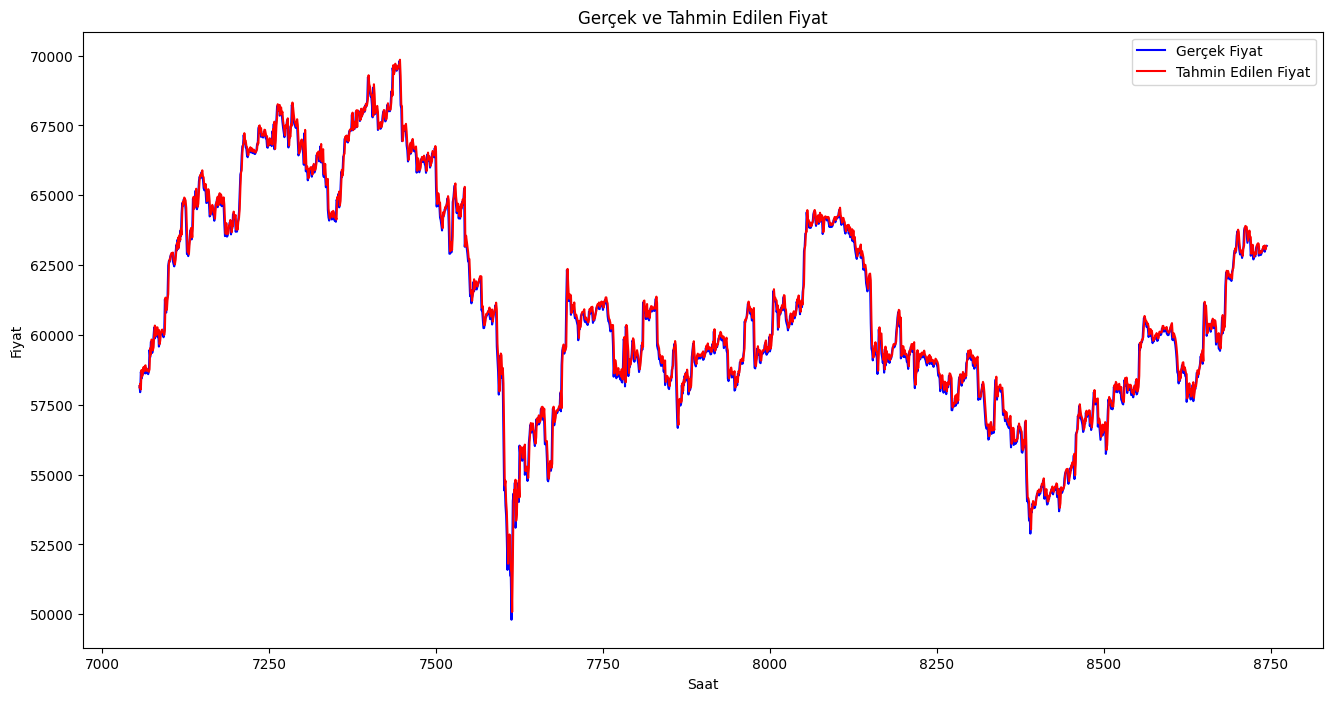

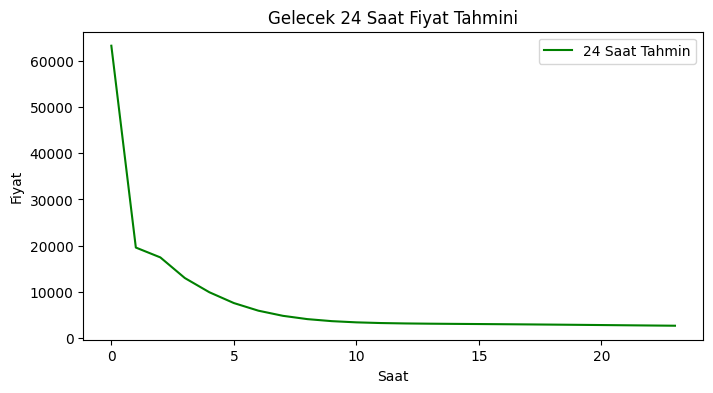

In [53]:
# --- 6. SONUÇLARIN GÖRSELLEŞTİRİLMESİ ---

# Test sonuçlarını ve tahminleri karşılaştır
plt.figure(figsize=(16, 8))
plt.plot(df.iloc[train_size + time_step:, 0], label='Gerçek Fiyat', color='blue')
plt.plot(np.arange(train_size + time_step, train_size + time_step + len(predictions)), predictions, label='Tahmin Edilen Fiyat', color='red')
plt.title('Gerçek ve Tahmin Edilen Fiyat')
plt.xlabel('Saat')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

# 24 saatlik tahmini göster
plt.figure(figsize=(8, 4))
plt.plot(predicted_24_hours, label='24 Saat Tahmin', color='green')
plt.title('Gelecek 24 Saat Fiyat Tahmini')
plt.xlabel('Saat')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

In [54]:
# Gerçek ve tahmin edilen fiyatlar arasındaki mutlak farkları hesapla
real_prices = df.iloc[train_size + time_step:, 0].values
price_differences = np.abs(real_prices[:1688] - predictions.flatten())  # Mutlak farkları al

# Maksimum ve minimum mutlak farkları bul
max_difference = np.max(price_differences)
min_difference = np.min(price_differences)

# Minimum farkın olduğu indeksi bul
min_difference_index = np.argmin(price_differences)

# Minimum farkın olduğu satırı göster
min_real_price = real_prices[min_difference_index]
min_predicted_price = predictions.flatten()[min_difference_index]
min_difference_value = price_differences[min_difference_index]

print(f'Maksimum Mutlak Fark: {max_difference:.2f}')
print(f'Minimum Mutlak Fark: {min_difference:.2f}')
print(f'Minimum Farkın Olduğu Satır: {min_difference_index + (train_size + time_step)}')
print(f'Minimum Fark: Gerçek Fiyat: {min_real_price:.2f}, Tahmin Edilen Fiyat: {min_predicted_price:.2f}, Fark: {min_difference_value:.2f}')


Maksimum Mutlak Fark: 2224.36
Minimum Mutlak Fark: 0.02
Minimum Farkın Olduğu Satır: 8001
Minimum Fark: Gerçek Fiyat: 59511.80, Tahmin Edilen Fiyat: 59511.78, Fark: 0.02
